# Analyse et Prédiction des Émissions CO2 des Véhicules

Ce notebook analyse un dataset de véhicules et développe un modèle de prédiction des émissions CO2.

In [3]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [4]:
# Chargement des données nettoyées
data = pd.read_csv('./files/train.csv')
print(f"Nombre total d'entrées : {len(data)}")
data.head()

Nombre total d'entrées : 41257


,id,brand,model,car_class,range,fuel_type,hybrid,max_power,grbx_type_ratios,weight_min,weight_max,urb_cons,exturb_cons,overall_cons,co,hc,nox,hcnox,ptcl,co2
0,0,MERCEDES,COMBI 110 CDI,MINIBUS,MOY-INFER,GO,non,70.0,M 6,1976,2075,9.1,6.4,7.4,0.083,NaN,0.229,0.250,0.001,195
1,1,MERCEDES,VIANO 2.0 CDI,MINIBUS,MOY-SUPER,GO,non,100.0,A 5,2186,2355,10.2,7.0,8.2,0.078,NaN,0.224,0.233,0.001,216
2,2,MERCEDES,SPRINTER COMBI 319 CDI,MINIBUS,MOY-INFER,GO,non,140.0,A 5,2586,2869,12.5,9.0,10.3,0.067,0.014,1.846,NaN,0.002,272
3,3,RENAULT,MEGANE Coupé EnergyTCe (115ch) eco2,COUPE,MOY-INFER,ES,non,85.0,M 6,1280,1280,6.4,4.6,5.3,0.167,0.039,0.039,NaN,0.001,119
4,4,MERCEDES,COMBI 116 CDI,MINIBUS,MOY-INFER,GO,non,120.0,A 5,2356,2450,10.1,6.9,8.1,0.042,NaN,0.190,0.201,0.001,214


## 1. Analyse Exploratoire des Données

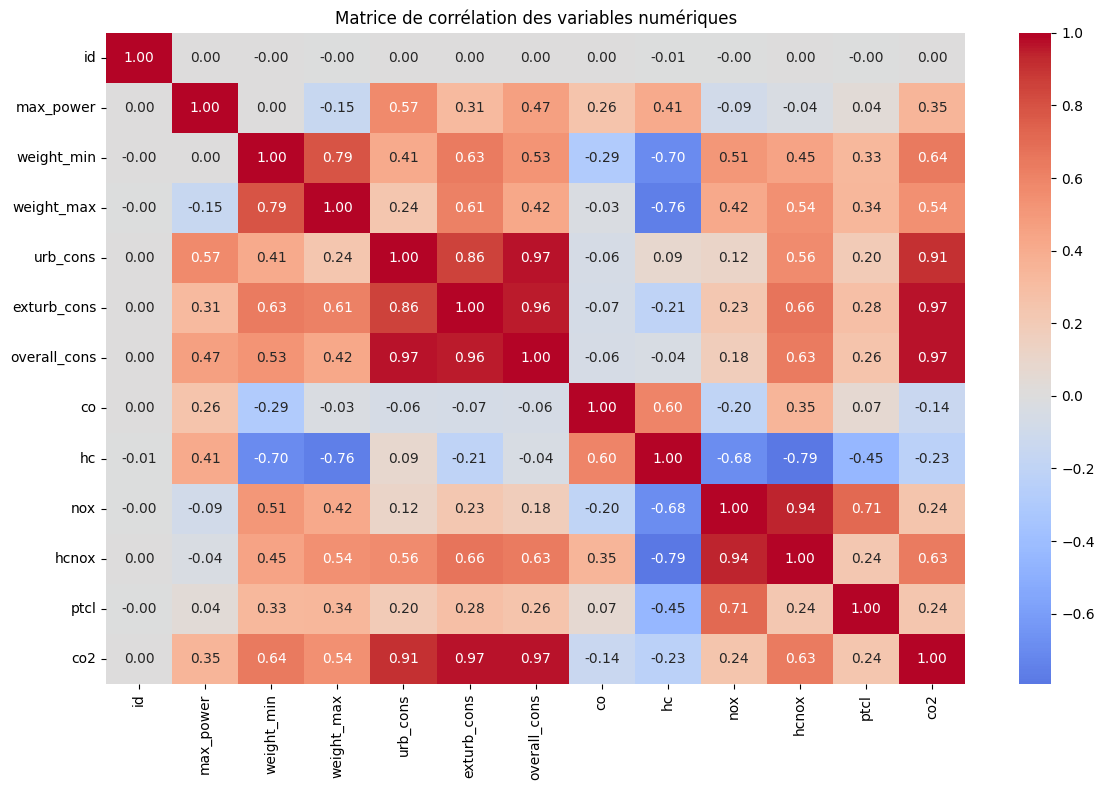

In [5]:
# Sélection des colonnes numériques
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
numeric_data = data[numeric_columns]

# Création de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matrice de corrélation des variables numériques')
plt.tight_layout()
plt.show()

In [6]:
# Analyse des variables catégorielles
categorical_columns = data.select_dtypes(include=['object']).columns

# Affichage des valeurs uniques pour chaque variable catégorielle
for col in categorical_columns:
    print(f"\nValeurs uniques dans {col}:")
    print(data[col].value_counts().head())
    print(f"Nombre total de valeurs uniques: {data[col].nunique()}")


Valeurs uniques dans brand:
brand
MERCEDES      27127
VOLKSWAGEN    10266
FIAT            394
BMW             342
OPEL            308
Name: count, dtype: int64
Nombre total de valeurs uniques: 44

Valeurs uniques dans model:
model
VIANO 2.2 CDI    4405
VIANO 2.0 CDI    2931
COMBI 116 CDI    2847
COMBI 113 CDI    1968
VIANO 3.0 CDI    1180
Name: count, dtype: int64
Nombre total de valeurs uniques: 3141

Valeurs uniques dans car_class:
car_class
MINIBUS                34570
BERLINE                 3307
BREAK                    933
TS TERRAINS/CHEMINS      819
COUPE                    661
Name: count, dtype: int64
Nombre total de valeurs uniques: 11

Valeurs uniques dans range:
range
MOY-INFER     25118
MOY-SUPER     11275
LUXE           2677
SUPERIEURE     1163
INFERIEURE      800
Name: count, dtype: int64
Nombre total de valeurs uniques: 7

Valeurs uniques dans fuel_type:
fuel_type
GO       36993
ES        3853
EH         233
GH          63
GN/ES       27
Name: count, dtype: int64
Nomb

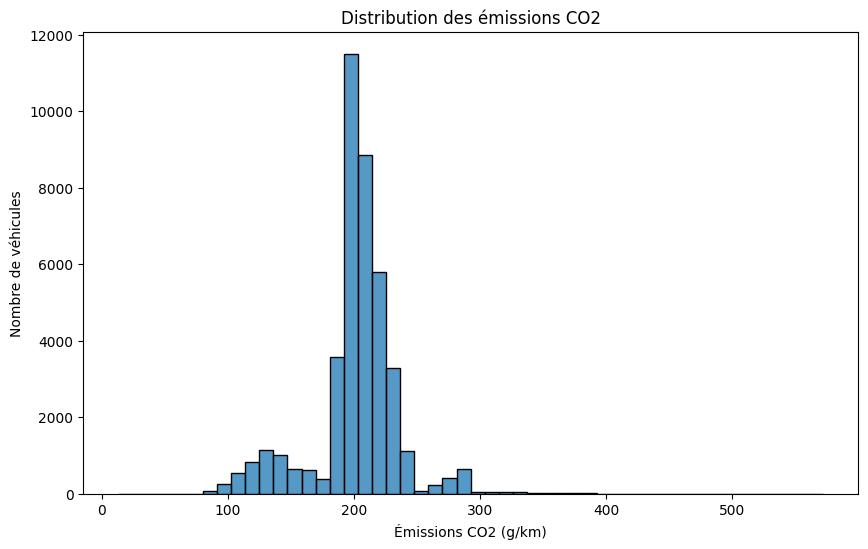

In [7]:
# Distribution des émissions CO2
plt.figure(figsize=(10, 6))
sns.histplot(data['co2'], bins=50)
plt.title('Distribution des émissions CO2')
plt.xlabel('Émissions CO2 (g/km)')
plt.ylabel('Nombre de véhicules')
plt.show()

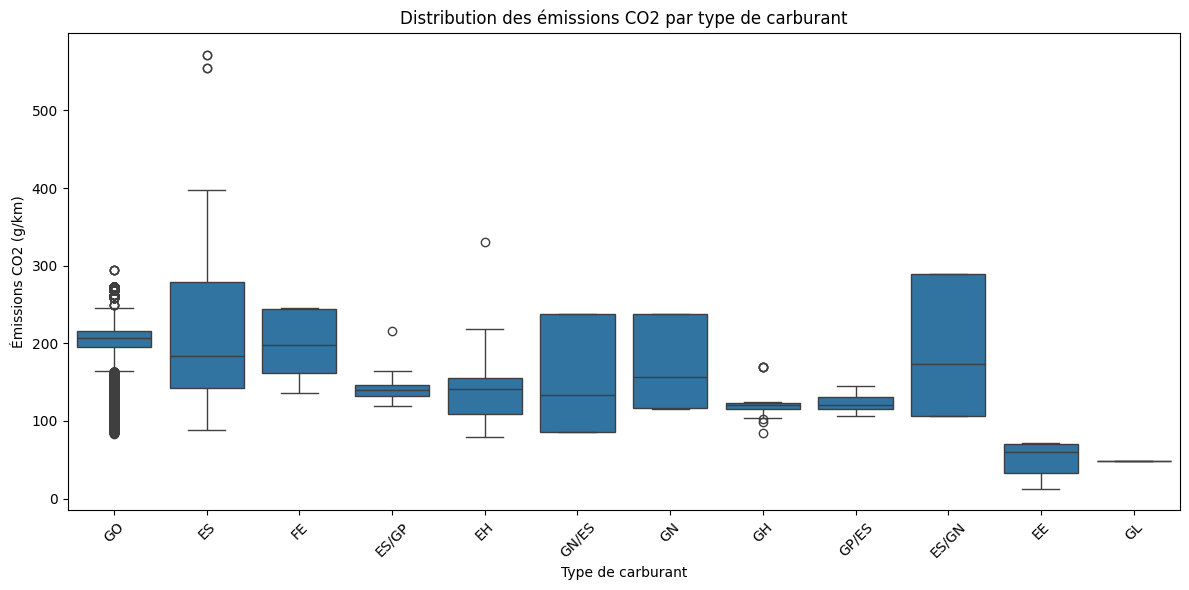

In [8]:
# Distribution des émissions CO2 par type de carburant
plt.figure(figsize=(12, 6))
sns.boxplot(x='fuel_type', y='co2', data=data)
plt.title('Distribution des émissions CO2 par type de carburant')
plt.xlabel('Type de carburant')
plt.ylabel('Émissions CO2 (g/km)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Préparation des Données

In [9]:
# Sélection des features
numeric_features = ['max_power', 'weight_min', 'weight_max', 'urb_cons', 
                    'exturb_cons', 'overall_cons', 'co', 'hc', 'nox', 'hcnox', 'ptcl']
categorical_features = ['brand', 'car_class', 'range', 'fuel_type', 'hybrid', 'grbx_type_ratios']

# Création des transformers
# remplace les valeurs manquantes par la moyenne puis normalise les données
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# remplace les valeurs manquantes par "missing" et convertit les catégories en nombres
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


# Création du preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [10]:
#import des données de tests 
test_data = pd.read_csv('./files/test.csv')

# Séparation des features et de la target pour l'entraînement
X_train = data[numeric_features + categorical_features]
y_train = data['co2']

X_test = test_data[numeric_features + categorical_features]

## 3. Modèles de Régression

In [11]:
# Fonction d'évaluation des modèles
def evaluate_model(model, X_train, X_test, y_train, model_name):
    # Création du pipeline complet
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Entraînement
    pipeline.fit(X_train, y_train)
    
    # Prédictions sur le set de test
    y_pred = pipeline.predict(X_test)
    
    # Cross-validation sur les données d'entraînement
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    
    print(f"\nRésultats pour {model_name}:")
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Moyenne CV R² score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    return y_pred, cv_scores.mean()

In [12]:
# Test de différents modèles
models = {
    'Régression Linéaire': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Stockage des prédictions et des scores
predictions = {}
scores = {}

for name, model in models.items():
    y_pred, cv_score = evaluate_model(model, X_train, X_test, y_train, name)
    predictions[name] = y_pred
    scores[name] = cv_score

# Création du fichier de soumission avec le meilleur modèle
best_model_name = max(scores.items(), key=lambda x: x[1])[0]
submission = pd.DataFrame({
    'id': test_data['id'],
    'co2': predictions[best_model_name]
})

# Sauvegarde des prédictions
submission.to_csv('./files/submission.csv', index=False)
print(f"\nPrédictions sauvegardées dans submission.csv (meilleur modèle: {best_model_name})")
print(f"Score du meilleur modèle: {scores[best_model_name]:.4f}")


Résultats pour Régression Linéaire:
Cross-validation R² scores: [ 9.97193357e-01 -2.68191561e+16  9.97617989e-01  9.97844004e-01
 -1.95685794e+14]
Moyenne CV R² score: -5402968379694307.0000 (+/- 21416724128784048.0000)

Résultats pour Ridge:
Cross-validation R² scores: [0.99715654 0.99773618 0.99753083 0.99789465 0.99792099]
Moyenne CV R² score: 0.9976 (+/- 0.0006)

Résultats pour Lasso:
Cross-validation R² scores: [0.97145705 0.9753008  0.96910304 0.97535838 0.9765786 ]
Moyenne CV R² score: 0.9736 (+/- 0.0056)

Résultats pour Random Forest:
Cross-validation R² scores: [0.99890163 0.99894404 0.99904641 0.99748495 0.99957728]
Moyenne CV R² score: 0.9988 (+/- 0.0014)

Résultats pour Gradient Boosting:
Cross-validation R² scores: [0.99834038 0.99788283 0.99814481 0.99786323 0.9982919 ]
Moyenne CV R² score: 0.9981 (+/- 0.0004)

Prédictions sauvegardées dans submission.csv (meilleur modèle: Random Forest)
Score du meilleur modèle: 0.9988


## 4. Analyse des Features Importantes

In [18]:
# Sélection du meilleur modèle (Random Forest)
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=45, random_state=42))
])

# Entraînement du modèle
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['max_power', 'weight_min',
                                                   'weight_max', 'urb_cons',
                                                   'exturb_cons',
                                                   'overall_cons', 'co', 'hc',
                                                   'nox', 'hcnox', 'ptcl']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['brand', 'car_class',
                                                   'range', 'fuel_type',
                                                   'hybrid',
                                                   'grbx_type_ratios'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=45, random_state=42))])


Top 10 des features les plus importantes :
         feature  importance
5   overall_cons    0.684021
4    exturb_cons    0.292898
3       urb_cons    0.005982
83  fuel_type_GO    0.005168
8            nox    0.003969
0      max_power    0.001683
7             hc    0.000987
9          hcnox    0.000980
2     weight_max    0.000888
75  fuel_type_ES    0.000546


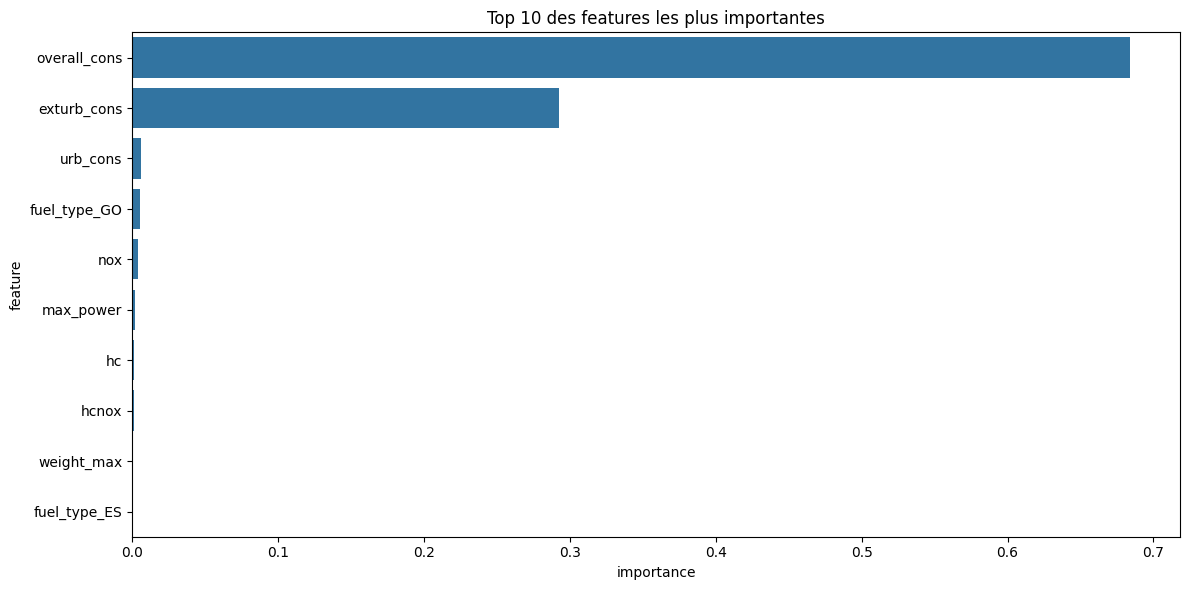


Importance moyenne par type de feature :
Numérique: 0.9922
fuel: 0.0069
range: 0.0004
car: 0.0001
grbx: 0.0002
hybrid: 0.0000
brand: 0.0002


In [14]:
# Extraction des features importantes
# On récupère d'abord les noms des features après l'encodage
feature_names = (
    numeric_features +  # Features numériques
    [f"{feat}_{val}" for feat, vals in zip(categorical_features, 
        best_model.named_steps['preprocessor']
        .named_transformers_['cat']
        .named_steps['onehot']
        .categories_) for val in vals]  # Features catégorielles encodées
)

# Création du DataFrame avec les importances
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.named_steps['regressor'].feature_importances_
})

# Tri par importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Affichage des 10 features les plus importantes
print("\nTop 10 des features les plus importantes :")
print(feature_importance.head(10))

# Visualisation des features importantes
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 des features les plus importantes')
plt.tight_layout()
plt.show()

# Analyse par type de feature
print("\nImportance moyenne par type de feature :")
feature_types = {}
for feat in feature_importance['feature']:
    if feat in numeric_features:
        feature_types['Numérique'] = feature_types.get('Numérique', 0) + feature_importance.loc[feature_importance['feature'] == feat, 'importance'].values[0]
    else:
        base_feat = feat.split('_')[0]
        feature_types[base_feat] = feature_types.get(base_feat, 0) + feature_importance.loc[feature_importance['feature'] == feat, 'importance'].values[0]

# Affichage des résultats
for feat_type, importance in feature_types.items():
    print(f"{feat_type}: {importance:.4f}")

Approfondissement : 


In [15]:
# Import des bibliothèques nécessaires
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

# 1. Préparation des données
# Encodage des variables catégorielles
label_encoders = {}
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in categorical_features:
    label_encoders[col] = LabelEncoder()
    X_train_encoded[col] = label_encoders[col].fit_transform(X_train[col])
    X_test_encoded[col] = label_encoders[col].transform(X_test[col])

# 2. Création des modèles de base avec leurs paramètres optimaux
base_models = [
    ('xgb', XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=7,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )),
    ('lgb', LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=7,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )),
    ('catboost', CatBoostRegressor(
        iterations=1000,
        learning_rate=0.01,
        depth=7,
        random_seed=42,
        verbose=False
    )),
    ('rf', RandomForestRegressor(
        n_estimators=1000,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )),
    ('gb', GradientBoostingRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=7,
        subsample=0.8,
        random_state=42
    ))
]

# 3. Optimisation des hyperparamètres pour chaque modèle de base
param_grids = {
    'xgb': {
        'max_depth': [5, 7, 9],
        'learning_rate': [0.01, 0.05],
        'n_estimators': [800, 1000, 1200],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    },
    'lgb': {
        'max_depth': [5, 7, 9],
        'learning_rate': [0.01, 0.05],
        'n_estimators': [800, 1000, 1200],
        'num_leaves': [31, 63],
        'subsample': [0.8, 0.9]
    },
    'rf': {
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'n_estimators': [800, 1000, 1200]
    },
    'gb': {
        'max_depth': [5, 7, 9],
        'learning_rate': [0.01, 0.05],
        'n_estimators': [800, 1000, 1200],
        'subsample': [0.8, 0.9]
    }
}

# 4. Optimisation des modèles
optimized_models = []
for name, model in base_models:
    if name in param_grids:
        print(f"\nOptimisation de {name}...")
        grid_search = GridSearchCV(
            model,
            param_grids[name],
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )
        grid_search.fit(X_train_encoded, y_train)
        optimized_models.append((name, grid_search.best_estimator_))
        print(f"Meilleurs paramètres pour {name}: {grid_search.best_params_}")
        print(f"Meilleur score: {grid_search.best_score_:.4f}")
    else:
        optimized_models.append((name, model))

# 5. Création du modèle de stacking final avec les modèles optimisés
final_estimator = Ridge(alpha=0.1)
final_stacking = StackingRegressor(
    estimators=optimized_models,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

# 6. Entraînement et évaluation du modèle final
print("\nEntraînement du modèle de stacking final...")
final_stacking.fit(X_train_encoded, y_train)

# 7. Prédictions sur le set de test
y_pred = final_stacking.predict(X_test_encoded)

# 8. Création du fichier de soumission
submission = pd.DataFrame({
    'id': test_data['id'],
    'co2': y_pred
})

# 9. Sauvegarde des prédictions
submission.to_csv('./files/submission.csv', index=False)
print("\nPrédictions sauvegardées dans submission.csv")

# 10. Analyse des performances
cv_scores = cross_val_score(final_stacking, X_train_encoded, y_train, cv=5, scoring='r2')
print(f"\nScore de validation croisée: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Optimisation de xgb...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Meilleurs paramètres pour xgb: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1200, 'subsample': 0.9}
Meilleur score: 0.9994

Optimisation de lgb...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1789
[LightGBM] [Info] Number of data points in the train set: 41257, number of used features: 17
[LightGBM] [Info] Start training from score 201.636086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

KeyboardInterrupt: 

In [ ]:
# Import des bibliothèques nécessaires
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 1. Préparation des données
# Encodage des variables catégorielles
label_encoders = {}
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in categorical_features:
    label_encoders[col] = LabelEncoder()
    X_train_encoded[col] = label_encoders[col].fit_transform(X_train[col])
    X_test_encoded[col] = label_encoders[col].transform(X_test[col])

# 2. Création du modèle XGBoost avec les meilleurs paramètres trouvés
best_xgb = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=1,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# 3. Entraînement du modèle XGBoost
print("Entraînement du modèle XGBoost avec les meilleurs paramètres...")
best_xgb.fit(X_train_encoded, y_train)

# 4. Évaluation du modèle
cv_scores = cross_val_score(best_xgb, X_train_encoded, y_train, cv=5, scoring='r2')
print(f"\nScore de validation croisée du modèle XGBoost: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 5. Prédictions sur le set de test
y_pred = best_xgb.predict(X_test_encoded)

# 6. Création du fichier de soumission
submission = pd.DataFrame({
    'id': test_data['id'],
    'co2': y_pred
})

# 7. Sauvegarde des prédictions
submission.to_csv('./files/submission_xgb.csv', index=False)
print("\nPrédictions sauvegardées dans submission_xgb.csv")

Entraînement du modèle XGBoost avec les meilleurs paramètres...

Score de validation croisée du modèle XGBoost: 0.9972 (+/- 0.0012)

Prédictions sauvegardées dans submission_xgb.csv
